In [ ]:
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer

import warnings
warnings.filterwarnings('ignore')
pd.set_option("display.max_columns", 500)

import os
from dotenv import load_dotenv
load_dotenv()

In [ ]:
user = os.getenv("POSTGRES_USER")
password = os.getenv("POSTGRES_PASSWORD")
host = os.getenv("POSTGRES_HOST")
port = os.getenv("POSTGRES_PORT")
db = os.getenv("POSTGRES_DATABASE")
db_url = f"postgresql://{user}:{password}@{host}:{port}/{db}"

In [ ]:
engine = create_engine(db_url)

df_data_feed = pd.read_sql("""SELECT * 
                      FROM feed_data
                      WHERE action = 'like'
                      """, 
                      con=engine, 
                      parse_dates="timestamp")

In [3]:
df_data_user = pd.read_sql("""SELECT * 
                      FROM user_data """, 
                      con=engine)

df_data_post = pd.read_sql("""SELECT * 
                      FROM post_text_df """, 
                      con=engine)


In [6]:
df_feed_likes = df_data_feed.copy()

In [7]:
df_post = df_data_post.copy()

In [8]:
df_user = df_data_user.copy()

## Обработка данных

### Работа с постами

Topic - категориальная фича

In [9]:
df_post.head()

,post_id,text,topic
0,1,UK economy facing major risks\n\nThe UK manufa...,business
1,2,Aids and climate top Davos agenda\n\nClimate c...,business
2,3,Asian quake hits European shares\n\nShares in ...,business
3,4,India power shares jump on debut\n\nShares in ...,business
4,5,Lacroix label bought by US firm\n\nLuxury good...,business


In [10]:
df_post = df_post.assign(
    num_of_symbols=lambda x: x['text'].apply(len),                    # кол-во символов в тексте
    num_of_words=lambda x: x['text'].apply(lambda s: len(s.split()))  # ко-во слов в тексте
)

In [11]:
#text - tfIdf

vectorizer = TfidfVectorizer()

tfidf_matrix = vectorizer.fit_transform(df_post.text)
tfidf_scores = tfidf_matrix.toarray()

df_post = df_post.assign(MeanTfIdf = np.mean(tfidf_scores, axis=1),   # средний tfIdf для слов в тексте
               MaxTfIdf = np.max(tfidf_scores, axis=1))                         # tfIdf для самого важного слова в тексте

In [12]:
df_post.drop('text', axis=1, inplace=True)

In [13]:
post_interactions = df_feed_likes.groupby('post_id').action.count()
df_post['post_popularity'] = df_post['post_id'].map(post_interactions).fillna(0)

### Работа с юзерами

country, city, exp_group, os, source, gender укажем как категориальные

In [15]:
df_user.head()

,user_id,gender,age,country,city,exp_group,os,source,user_like_amount
0,200,1,34,Russia,Degtyarsk,3,Android,ads,43.0
1,201,0,37,Russia,Abakan,0,Android,ads,58.0
2,202,1,17,Russia,Smolensk,4,Android,ads,87.0
3,203,0,18,Russia,Moscow,1,iOS,ads,61.0
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads,23.0


In [14]:
like_counts = df_feed_likes.groupby('user_id').action.count()
df_user['user_like_amount'] = df_user['user_id'].map(like_counts).fillna(0)    #сколько лайкал конкретный юзер

### Мэтчим таблицы для обучения, довливаем дополнительные фичи

In [14]:
df_data = pd.read_sql("""SELECT * 
                      FROM feed_data
                      LIMIT 1000000""", 
                      con=engine, 
                      parse_dates="timestamp")

In [15]:
df_data_copy = df_data.copy()

In [16]:
df = pd.merge(df_data_copy,
              df_post,
              on='post_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity
0,2021-12-21 08:50:29,108959,4203,view,0,covid,84,11,0.000061,0.481294,2777.0
1,2021-12-21 08:50:53,108959,1138,view,0,politics,2475,407,0.000233,0.349017,1639.0
2,2021-12-21 08:52:04,108959,1388,view,0,sport,2607,421,0.000235,0.349476,2756.0
3,2021-10-11 06:46:37,108960,5434,view,1,movie,2371,409,0.000268,0.250220,679.0
4,2021-10-11 06:49:31,108960,5434,like,0,movie,2371,409,0.000268,0.250220,679.0


In [17]:
df = pd.merge(df,
              df_user,
              on='user_id',
              how='left')

df.head()

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source
0,2021-12-21 08:50:29,108959,4203,view,0,covid,84,11,0.000061,0.481294,2777.0,0,32,Russia,Degtyarsk,2,iOS,organic
1,2021-12-21 08:50:53,108959,1138,view,0,politics,2475,407,0.000233,0.349017,1639.0,0,32,Russia,Degtyarsk,2,iOS,organic
2,2021-12-21 08:52:04,108959,1388,view,0,sport,2607,421,0.000235,0.349476,2756.0,0,32,Russia,Degtyarsk,2,iOS,organic
3,2021-10-11 06:46:37,108960,5434,view,1,movie,2371,409,0.000268,0.250220,679.0,0,43,Russia,Balakovo,4,Android,organic
4,2021-10-11 06:49:31,108960,5434,like,0,movie,2371,409,0.000268,0.250220,679.0,0,43,Russia,Balakovo,4,Android,organic


In [18]:
# some new features
 
df['hour'] = df.timestamp.dt.hour
df['month'] = df.timestamp.dt.month
df['day'] = df.timestamp.dt.day
df['week_day'] = df.timestamp.dt.dayofweek

In [19]:
#df.head()
df[df.action != 'like'].sort_values("timestamp", ascending=True)

,timestamp,user_id,post_id,action,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source,hour,month,day,week_day
283238,2021-10-01 06:01:40,108994,5258,view,0,movie,741,137,0.000170,0.289392,2689.0,1,17,Russia,Kirov,4,Android,organic,6,10,1,4
606263,2021-10-01 06:01:40,8663,3837,view,1,covid,140,21,0.000078,0.339822,2602.0,0,23,Russia,Volzhskiy,1,iOS,ads,6,10,1,4
283239,2021-10-01 06:02:01,108994,1454,view,0,sport,2172,420,0.000208,0.378863,2874.0,1,17,Russia,Kirov,4,Android,organic,6,10,1,4
606265,2021-10-01 06:02:01,8663,1779,view,0,sport,1551,289,0.000192,0.457397,2659.0,0,23,Russia,Volzhskiy,1,iOS,ads,6,10,1,4
66954,2021-10-01 06:03:20,59346,1496,view,1,sport,2167,387,0.000224,0.443658,2792.0,1,22,Russia,Vyshniy Volochëk,1,iOS,ads,6,10,1,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
518914,2021-12-29 23:41:05,100759,2748,view,1,covid,138,26,0.000081,0.486231,2412.0,0,29,Russia,Nizhniy Tagil,4,iOS,ads,23,12,29,2
672927,2021-12-29 23:41:05,73120,171,view,1,business,873,143,0.000158,0.460829,1079.0,0,65,Russia,Izhevsk,2,iOS,ads,23,12,29,2
615234,2021-12-29 23:43:15,163074,5335,view,0,movie,798,156,0.000167,0.306491,665.0,0,27,Russia,Shadrinsk,0,iOS,organic,23,12,29,2
672929,2021-12-29 23:43:15,73120,5170,view,0,movie,530,107,0.000139,0.294572,688.0,0,65,Russia,Izhevsk,2,iOS,ads,23,12,29,2


## Train, Test

In [20]:
#фильтрация для формирования трэин\тест
# плюсом фильтруем по action и удаляем действия с лайком - нужная информация из таких взаимодействий ранее была выделена

df_views = df[df.action != 'like'].sort_values("timestamp", ascending=True, ignore_index=True)
df_views.drop(['timestamp', 'action'], inplace=True, axis=1)

In [21]:
df_views.head()

,user_id,post_id,target,topic,num_of_symbols,num_of_words,MeanTfIdf,MaxTfIdf,post_popularity,gender,age,country,city,exp_group,os,source,hour,month,day,week_day
0,108994,5258,0,movie,741,137,0.000170,0.289392,2689.0,1,17,Russia,Kirov,4,Android,organic,6,10,1,4
1,8663,3837,1,covid,140,21,0.000078,0.339822,2602.0,0,23,Russia,Volzhskiy,1,iOS,ads,6,10,1,4
2,108994,1454,0,sport,2172,420,0.000208,0.378863,2874.0,1,17,Russia,Kirov,4,Android,organic,6,10,1,4
3,8663,1779,0,sport,1551,289,0.000192,0.457397,2659.0,0,23,Russia,Volzhskiy,1,iOS,ads,6,10,1,4
4,59346,1496,1,sport,2167,387,0.000224,0.443658,2792.0,1,22,Russia,Vyshniy Volochëk,1,iOS,ads,6,10,1,4


In [48]:
df_views.shape[1] -1 -1

16

In [22]:
df_views.drop(['user_id', 'post_id'], axis=1, inplace=True)

In [23]:
train_data = df_views.iloc[:-1000].copy()
test_data = df_views.iloc[-1000:].copy()

In [24]:
X_train = train_data.drop('target', axis=1)
y_train = train_data.target

In [25]:
X_test = test_data.drop('target', axis=1)
y_test = test_data.target

In [26]:
df_views.columns

Index(['target', 'topic', 'num_of_symbols', 'num_of_words', 'MeanTfIdf',
       'MaxTfIdf', 'post_popularity', 'gender', 'age', 'country', 'city',
       'exp_group', 'os', 'source', 'hour', 'month', 'day', 'week_day'],
      dtype='object')

In [29]:
from catboost import CatBoostClassifier

cat_cols =['topic', 'gender',
           'country', 'city', 'exp_group', 'os', 'source',
            'hour', 'month', 'day', 'week_day']


catboost = CatBoostClassifier(iterations=110,
                              learning_rate=1,
                              depth=2)

catboost.fit(X_train, y_train, cat_cols)

0:	learn: 0.3760111	total: 353ms	remaining: 38.5s
1:	learn: 0.3588649	total: 505ms	remaining: 27.2s
2:	learn: 0.3559396	total: 681ms	remaining: 24.3s
3:	learn: 0.3547015	total: 809ms	remaining: 21.4s
4:	learn: 0.3531015	total: 897ms	remaining: 18.8s
5:	learn: 0.3433153	total: 963ms	remaining: 16.7s
6:	learn: 0.3426976	total: 1.05s	remaining: 15.4s
7:	learn: 0.3422175	total: 1.11s	remaining: 14.2s
8:	learn: 0.3420338	total: 1.2s	remaining: 13.5s
9:	learn: 0.3415991	total: 1.27s	remaining: 12.7s
10:	learn: 0.3408062	total: 1.34s	remaining: 12.1s
11:	learn: 0.3406627	total: 1.41s	remaining: 11.5s
12:	learn: 0.3405283	total: 1.47s	remaining: 11s
13:	learn: 0.3403979	total: 1.54s	remaining: 10.5s
14:	learn: 0.3402319	total: 1.6s	remaining: 10.1s
15:	learn: 0.3401777	total: 1.66s	remaining: 9.78s
16:	learn: 0.3400094	total: 1.73s	remaining: 9.45s
17:	learn: 0.3399683	total: 1.81s	remaining: 9.27s
18:	learn: 0.3391312	total: 1.88s	remaining: 9.01s
19:	learn: 0.3389686	total: 1.95s	remaining: 

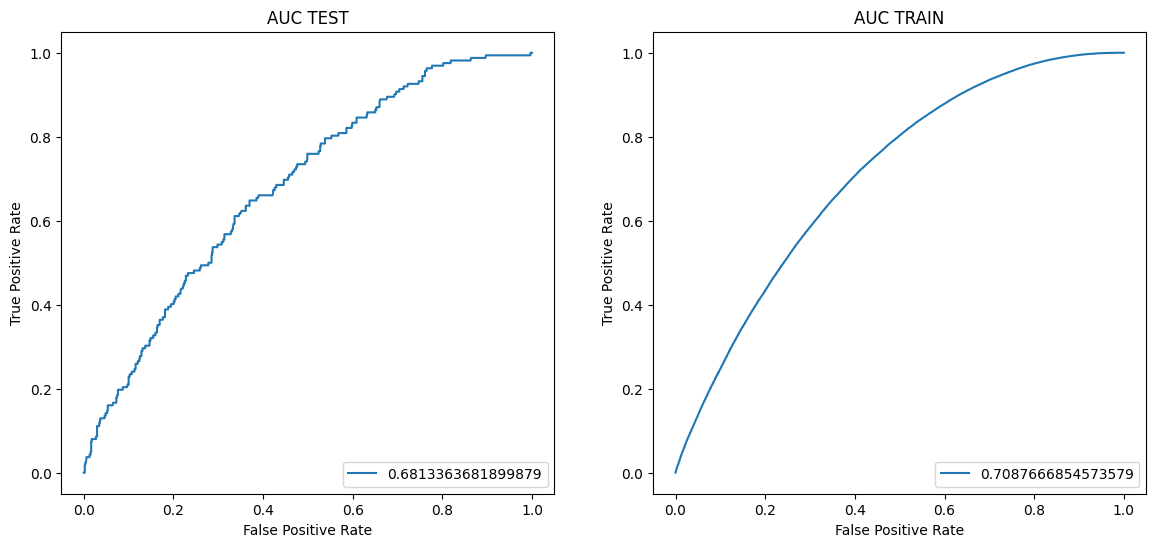

In [30]:
from sklearn.metrics import precision_recall_curve, roc_curve, RocCurveDisplay, auc

fig, ax = plt.subplots(1, 2, figsize=(14,6))

FPR, TPR, thresh = roc_curve(y_test, catboost.predict_proba(X_test)[:, 1])
RocCurveDisplay(fpr=FPR, tpr=TPR).plot(label = auc(FPR, TPR), ax=ax[0])
ax[0].set_title('AUC TEST')

FPR, TPR, thresh = roc_curve(y_train, catboost.predict_proba(X_train)[:, 1])
RocCurveDisplay(fpr=FPR, tpr=TPR).plot(label = auc(FPR, TPR), ax=ax[1])
ax[1].set_title('AUC TRAIN')
plt.show()

In [31]:
catboost.save_model('catboost_model3', format="cbm")

## Передача в БД

In [ ]:
TABLE_CUSTOM_POST = os.getenv("TABLE_CUSTOM_POST")
TABLE_CUSTOM_USERS = os.getenv("TABLE_CUSTOM_USERS")
TABLE_CUSTOM_POST_FEATURES = os.getenv("TABLE_CUSTOM_POST_FEATURES")

In [ ]:
df_user.to_sql(f'{TABLE_CUSTOM_USERS}', engine, if_exists='replace', index=False)

205

In [ ]:
df_post.to_sql(f'{TABLE_CUSTOM_POST}', engine, if_exists='replace', index=False)

23

In [ ]:
x = pd.read_sql("""SELECT * 
                    FROM {TABLE_CUSTOM_USERS};
                    """, con=engine)

In [50]:
x

,user_id,gender,age,country,city,exp_group,os,source
0,200,1,34,Russia,Degtyarsk,3,Android,ads
1,201,0,37,Russia,Abakan,0,Android,ads
2,202,1,17,Russia,Smolensk,4,Android,ads
3,203,0,18,Russia,Moscow,1,iOS,ads
4,204,0,36,Russia,Anzhero-Sudzhensk,3,Android,ads
...,...,...,...,...,...,...,...,...
163200,168548,0,36,Russia,Kaliningrad,4,Android,organic
163201,168549,0,18,Russia,Tula,2,Android,organic
163202,168550,1,41,Russia,Yekaterinburg,4,Android,organic
163203,168551,0,38,Russia,Moscow,3,iOS,organic
